Tara MicV Temperature Figure 2a and 2c 

### Set up environment and load dataset ###

In [4]:
#Import library
library(magrittr)
library(ggplot2, quietly = TRUE)
library(RColorBrewer)
library(tidyverse)
library(pryr)

In [5]:
# Workspace
rm(list=ls())
workdir = "../" # Set your path
# workdir = "~/Dropbox/0_Jupyter/MpV_paper_GitHub"
setwd(workdir)
#getwd()

### Load MpV abundance table and define optimal temperature ### 

In [6]:

# Load df (Each "factor" will be changed to "numeric")
df_MicV_Pico_stdz_sel <-  read_tsv("./data/df_MicV_Pico_stdz_sel.txt", col_names = TRUE, show_col_types = FALSE) #including sample label
# Here try using only a Pico-sized fraction

# Load id-clade table
MicV_total_ids_clades <-  read_tsv("./data/MicV_total_ids_clades.txt", col_names = TRUE, show_col_types = FALSE) #including sample lavel


# Convert to df and remove columns without Temp (There are two NA in the Temp column)
df <- as.data.frame(df_MicV_Pico_stdz_sel)
df <- filter(df, Temperature != "NA")
df_sub <- df[,17:ncol(df)] %>%  mutate_at(vars(everything()), na_if, y = 0) 
df <- cbind(df[,1:16], df_sub)

# Check the maximal adapted thermal ranges for each MpV and define the thermotype
start <- 17
end <- ncol(df)
thermotype_list <- NULL
for (i in start:end){
  gene <- colnames(df)[i]                    # Name of the gene
  max_freq <- max(df[,i], na.rm = TRUE)      # max value 
  mean_freq <- mean(df[,i], na.rm = TRUE)    # mean value "at the emerging sites"
  max_row <- which.max(as.vector(df[,i]))    # row number of the max
  opt_temp <- df[max_row, 11]                # temp corresponds to the max value
  if(opt_temp >= 20){                        # Define thermotype (thermotype)
    thermotype <- "high"
  } else if(20 > opt_temp & opt_temp >= 10){
    thermotype <- "medium"
  } else if(10 > opt_temp){
    thermotype <- "low"
  }
  #print(c(gene, max_freq, max_row, opt_temp, thermotype))
  d <- data.frame(gene, mean_freq, max_freq, opt_temp, thermotype)
  thermotype_list <- rbind(thermotype_list, d)
}

# Save df
write_tsv(thermotype_list, "thermotype_list.txt", col_names = TRUE)
write_tsv(as.data.frame(thermotype_list$gene), "geneids.txt", col_names = FALSE)

# Add clade info to thermo type list
MicV_total_ids_clades2 <- MicV_total_ids_clades
colnames(MicV_total_ids_clades2)[1] <- "gene"
thermotype_clade_list <- inner_join(thermotype_list, MicV_total_ids_clades2, by ="gene")
#write_tsv(thermotype_clade_list, "thermotype_clade.list.table", col_names = TRUE)


### Extract statistics of abundance/temperature distribution of each MicV for Fig. 2a ###

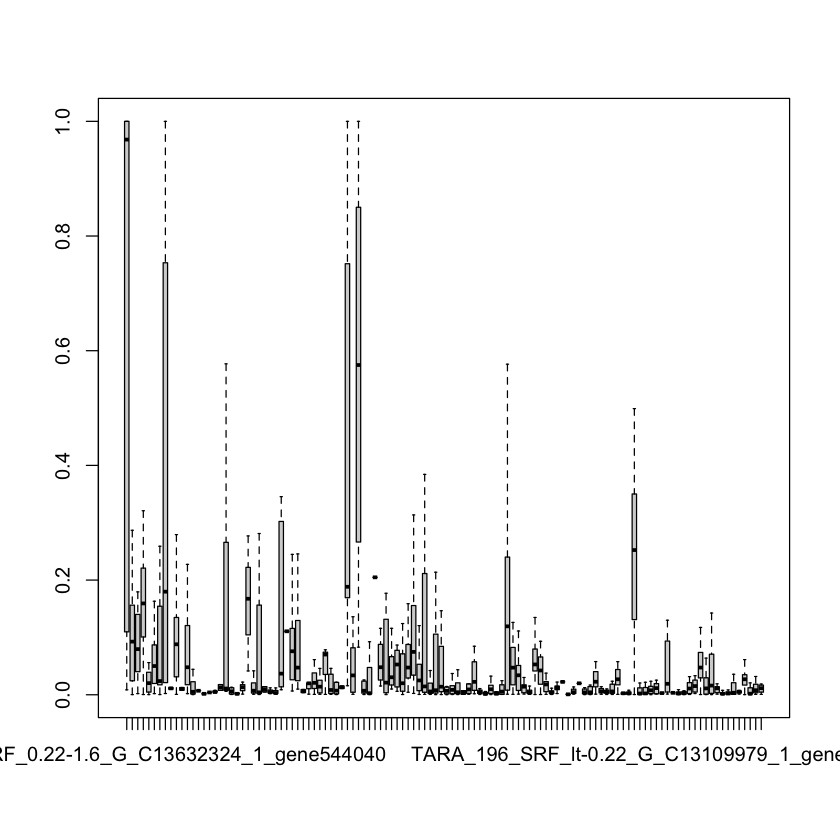

In [7]:
# Min, 1st Quartile. Median, Third Quartile, and Maximum values can be seen by "boxplot(df)$stats"

# Stats for Frequency
Freq_stats_list <- as.data.frame(t(boxplot(df[,17:ncol(df)], outline=F)$stats))
colnames(Freq_stats_list) <- c("Freq_Min", "Freq_1tile", "Freq_median", "Freq_3tile", "Freq_Max")
gene <- as.data.frame(colnames(df)[17:ncol(df)])
colnames(gene) <- "gene"
Freq_stats_list <- data.frame(gene, Freq_stats_list)

# Stats for Temperature
    # Silencing as it emerges huge set of plot
#start <- 17
#end <- ncol(df)
#Temp_stats_list <- NULL
#for (i in start:end){
#  gene <- colnames(df)[i] # Extract gene id
#  sel <- df[complete.cases(df[,i]),] # Remove lows with NA in the column i
#  Tstat <-  as.data.frame(t(boxplot(sel$Temperature, outline=F)$stats)) # Stats for boxplot 
#  colnames(Tstat) <- c("Temp_Min", "Temp_1tile", "Temp_median", "Temp_3tile", "Temp_Max")
#  e <- data.frame(gene, Tstat) # Merge df
#  Temp_stats_list <- rbind(Temp_stats_list, e)
#}

#write_csv(Freq_stats_list, "Freq_stats_list.csv", col_names = TRUE)
#write_csv(Temp_stats_list, "Temp_stats_list.csv", col_names = TRUE)


### Generate boxplot summarizing the optimal temperature (Fig. 2c) ###

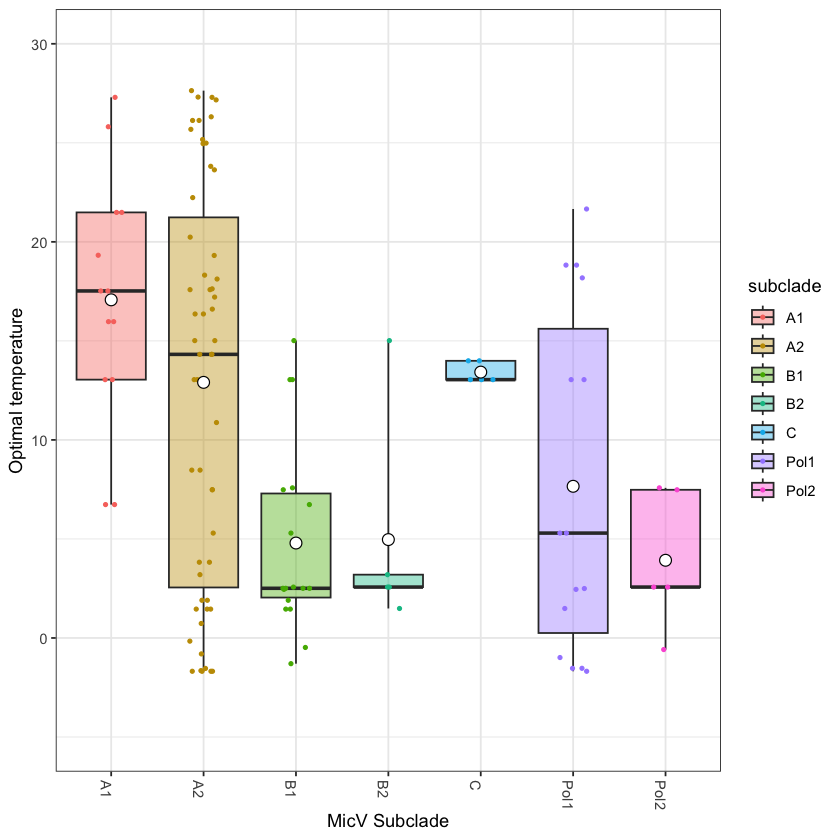

In [8]:
# Load MicV thermotype
thermotype_list2 <-  read_tsv("./data/thermotype_list.txt", col_names = TRUE, show_col_types = FALSE)
colnames(thermotype_list2)[1] <- c("ids")

# Load id-clade table
MicV_total_ids_clades <-  read_tsv("./data/MicV_total_ids_clades.txt", col_names = TRUE, show_col_types = FALSE)

# Merge dfs
clade_thermo_df <- left_join(thermotype_list2, MicV_total_ids_clades, by = "ids")

# Colors of A1, A2, B1, B2, C, Pol1, Pol2 for paper
col_subclade  <- c('#F8766D', '#C49A00', '#53B400', '#00C094', '#00B6EB', '#A58AFF', '#FB61D7')


# Box plot for each subclade
boxp1 <- ggplot(clade_thermo_df, aes(x=subclade, y=opt_temp, fill=subclade)) +
  geom_boxplot(coef=20, alpha=0.4) + # Change whiskers length for min to max.
  theme_bw() + 
  #scale_color_manual(breaks = c("Intra-genus", "Inter-genus"), values = col_tax) + 
  scale_fill_manual(values = col_subclade) +
  scale_y_continuous(limits = c(-5, 30)) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0)) +
  geom_jitter(aes(color = subclade), width=0.15, shape=19, size =0.8, alpha=1) +
  scale_color_manual(values = col_subclade) +
  stat_summary(fun = "mean", geom = "point", shape = 21, size = 3, fill = "white") +
  ylab("Optimal temperature") + xlab("MicV Subclade")
print(boxp1)
ggsave(filename = "Fig.opt_temp_boxplot_subclade_paper.pdf", plot= boxp1, width=120, height=90, units="mm", dpi = 300)
